In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

from utils.constants import *
from utils.generator import Generator
from utils.discriminator import Discriminator

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))
PATH = "./saved_models"

cpu


In [2]:
img_paths = []
for path in os.listdir(data_dir + '/monet_'):
    img_paths.append(path)

print("There are {} style images in Monet Paintings Dataset".format(len(img_paths)))

There are 300 style images in Monet Paintings Dataset


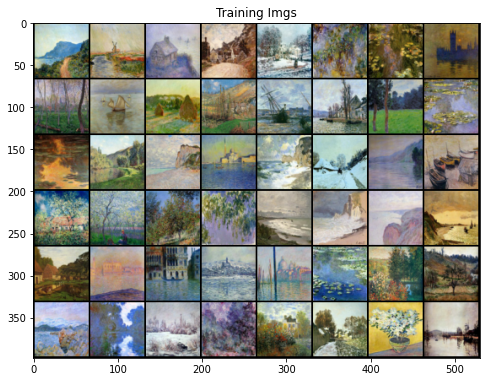

In [6]:
dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([transforms.Resize(image_size),
                                                         transforms.CenterCrop(image_size),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         shuffle=True, 
                                         num_workers=workers, 
                                         pin_memory=True)

sample = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.title("Training Imgs")
plt.imshow(np.transpose(vutils.make_grid(sample[0].to(device)[:48], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# function to initialize weights for model
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [11]:
net_g = Generator().to(device)
net_g.apply(init_weights)

print(net_g)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
net_d = Discriminator().to(device)
net_d.apply(init_weights)

print(net_d)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
# load existing models
if (os.path.exists(f"{PATH}/net_g")):
    net_g.load_state_dict(torch.load(f"{PATH}/net_g"))
    
if (os.path.exists(f"{PATH}/net_d")):
    net_d.load_state_dict(torch.load(f"{PATH}/net_d"))

In [16]:
# use Binary CE loss
criterion = nn.BCELoss()

# adam optimizers for discriminator & generator
optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))

# latent vectors
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# constants for real and fake labels
real_label = 1.
fake_label = 0.

In [15]:
# create losses log file for DCGAN
f = open("./losses.txt", "a")
f.write("Losses log for DCGAN\n")

21

In [16]:
def get_error_output(net, data, criterion, label):
    out = net(data).view(-1)
    D_err = criterion(out, label)
    D_err.backward()
    return D_err, out

In [22]:
# trainings

itrs = 0
imgs = []
G_loss = []
D_loss = []

print("Starting Training Loop...")

# loop through all epochs and batches
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        ## Update discriminators: maximize log(D(x)) + log(1 - D(G(z))) ##
        net_d.zero_grad()
        
        # format real batch data
        curr_data = data[0].to(device)
        batch_size = curr_data.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        D_err_real, out = get_error_output(net=net_d, data=data, criterion=criterion, label=label)
        D_x = out.mean().item()

        # fake data
        noise = torch.randn(batch_size, nz, 1, 1, device=device) # generate noise
        fake_data = net_g(noise)
        label.fill_(fake_label)
        
        D_err_fake, out = get_error_output(net=net_g, data=fake_data.detach(), criterion=criterion, label=label)
        
        D_err = D_err_real + D_err_fake
        
        optimizer_d.step()
        
        D_G_z1 = out.mean().item()

        ## Update generator: maximize log(D(G(z))) ##
        net_g.zero_grad()
        label.fill_(real_label)  
        
        out = net_d(fake_data).view(-1)
        G_err = criterion(out, label)
        G_err.backward()
        optimizer_g.step()

        D_G_z2 = out.mean().item()
        
        # losses
        G_loss.append(G_err.item())
        D_loss.append(D_err.item())
        
        # log stats
        if i % 50 == 0:
            log_str = f"[{epoch}/{num_epochs}][{i}/{len(dataloader}]\tLoss_D: {D_err.item():.4f}\tLoss_G: {G_err.item():.4f}
                \tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}"
            
            print(log_str)
            f.write(f"{log_str}\n") # write to the log file
            f.flush()

        # save models every 500th iteration or when the training finishes
        if (itrs % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
                
            imgs.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            torch.save(net_g.state_dict(), f"{PATH}/net_g")
            torch.save(net_d.state_dict(), f"{PATH}/net_d")
        
        itrs += 1
        
f.close()

Starting Training Loop...
[0/1000][0/3]	Loss_D: 0.0724	Loss_G: 8.0219	D(x): 0.9423	D(G(z)): 0.0009 / 0.0007
[1/1000][0/3]	Loss_D: 0.3627	Loss_G: 7.5799	D(x): 0.8764	D(G(z)): 0.1434 / 0.0009


KeyboardInterrupt: 

In [58]:
# save model once again to be safe
torch.save(net_g.state_dict(), f"{PATH}/net_g")
torch.save(net_d.state_dict(), f"{PATH}/net_d")

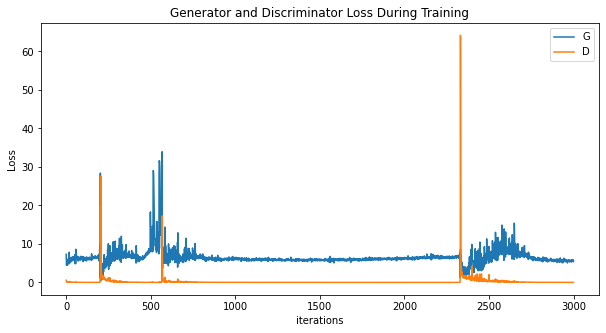

In [59]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

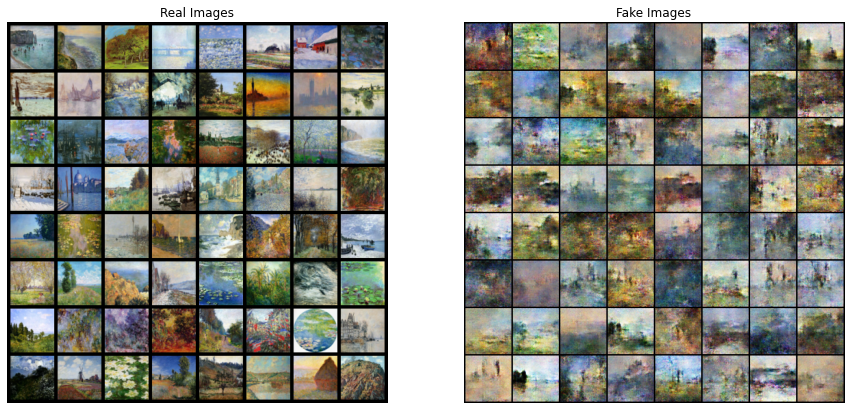

In [60]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imgs[-1],(1,2,0)))
plt.show()